In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.stats as scst
import altair as al
import matplotlib.pyplot as plt
import matplotlib.colors as pcl
import palettable 
from ggplot import *
%matplotlib inline




/Users/stefan/.pyenv/versions/miniconda2-4.1.11/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/stefan/.pyenv/versions/miniconda2-4.1.11/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/stefan/.pyenv/versions/miniconda2-4.1.11/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
b_growth = pd.read_csv('../Data/growth-raw.csv')
plate_map = pd.read_csv('../Data/platemap.csv')
m_growth = b_growth.melt(id_vars=['Time','Temperature'],
                             value_vars=b_growth.columns[2:],
                             value_name='OD600',
                             var_name='Well')
map_growth = pd.merge(m_growth,plate_map,on='Well',how='inner')
gr_growth = map_growth.drop('Well',axis=1).groupby(['Strain','Environment','Time'])['OD600'].agg(['count',np.mean,np.std])

In [10]:
map_growth.head(10)

,Time,Temperature,Well,OD600,Strain,Environment
0,0,28.2,B2,0.6100,A,1
1,20,28.9,B2,0.5603,A,1
2,40,29.3,B2,0.1858,A,1
3,60,29.8,B2,0.1733,A,1
4,80,30.2,B2,0.1713,A,1
5,100,30.6,B2,0.1714,A,1
6,120,30.9,B2,0.1716,A,1
7,140,31.3,B2,0.1707,A,1
8,160,31.7,B2,0.1709,A,1
9,180,31.9,B2,0.1706,A,1


In [15]:
gr_growth = (map_growth.loc[map_growth['Temperature']==37.0]
             .drop('Well',axis=1)
             .groupby(['Strain','Environment','Time'])['OD600']
             .agg(['count',np.mean,np.std])
             .reset_index()
             .assign(CI_L=lambda x: sp.stats.t.interval(0.95, x['count']-1, loc=x['mean'], 
                                                                scale=x['std']/np.sqrt(x['count']))[0],
                            CI_R=lambda x: sp.stats.t.interval(0.95, x['count']-1, loc=x['mean'], 
                                                               scale=x['std']/np.sqrt(x['count']))[1],
                            hours=lambda x:x['Time']/3600))


In [18]:
gr_growth.head()

,Strain,Environment,Time,count,mean,std,CI_L,CI_R,hours
0,A,1,0,4,1.581725,0.007203,1.570263,1.593187,0.000000
1,A,1,20,4,1.580400,0.007365,1.568680,1.592120,0.005556
2,A,1,40,4,1.582325,0.007537,1.570332,1.594318,0.011111
3,A,1,60,4,1.580575,0.006590,1.570090,1.591060,0.016667
4,A,1,80,4,1.581125,0.007047,1.569912,1.592338,0.022222


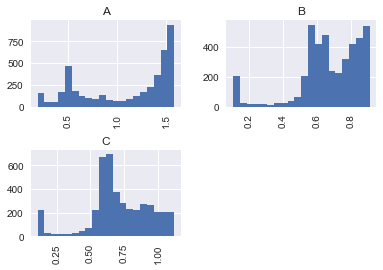

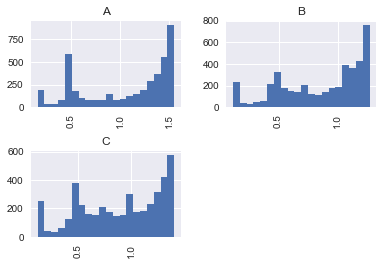

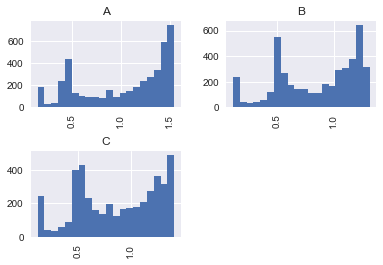

In [31]:
gr_growth.groupby(['Environment'])['mean'].hist(gr_growth['Strain'], bins=20, color ="Environment");

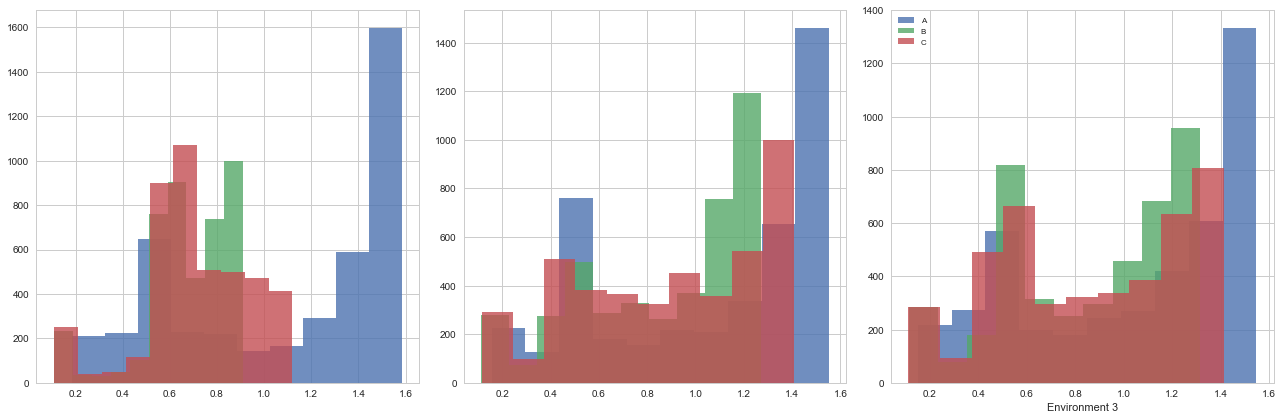

In [94]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(18, 6))
    for facet,cnt in zip(gr_growth['Environment'].unique(),range(3)):
        plt.subplot(1, 3, cnt+1)
        plot_growth = gr_growth.loc[gr_growth['Environment']==facet,:]
        for strain in plot_growth['Strain'].unique():
            plt.hist(plot_growth.loc[plot_growth['Strain']==strain,:]['mean'],
                    label=str(strain),
                    bins=10,
                    alpha=.8)
    plt.xlabel("Environment " + str(cnt+1))
    plt.legend(loc='best', fancybox=True, fontsize=8)
    plt.tight_layout()
    plt.show()

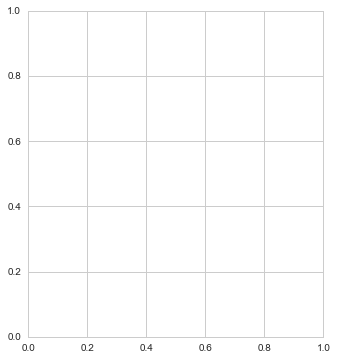

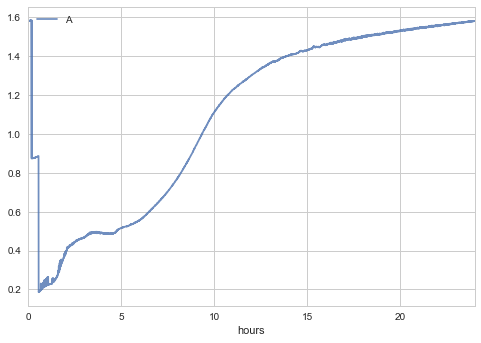

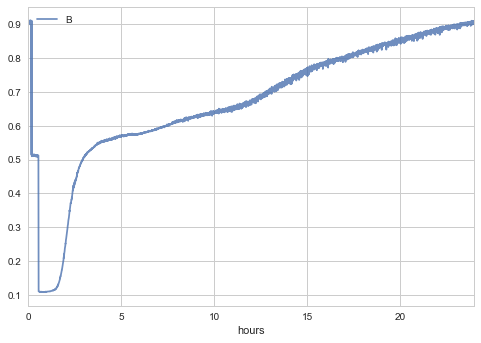

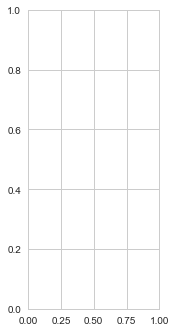

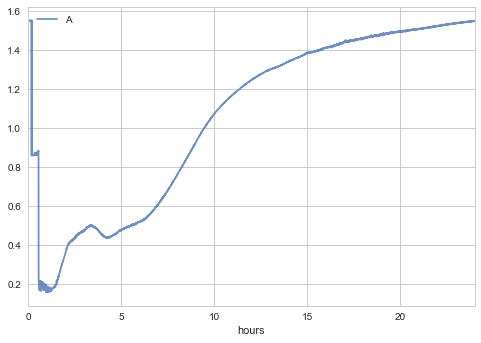

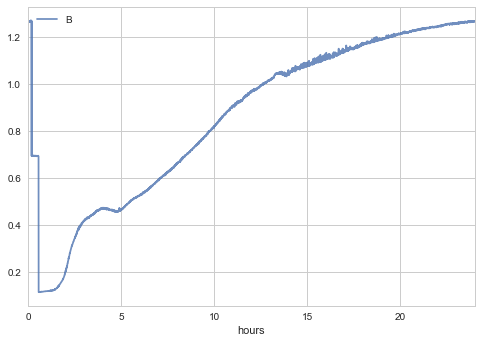

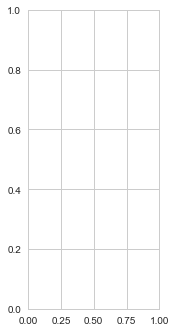

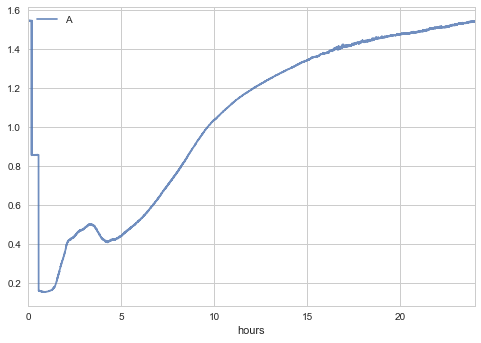

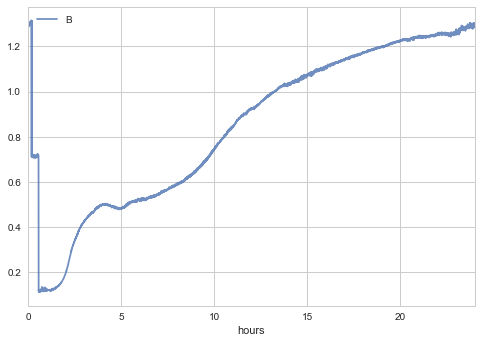

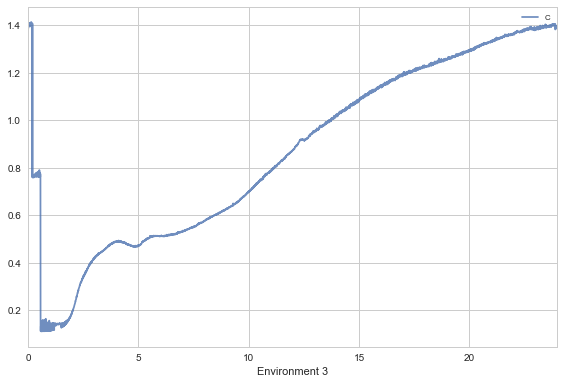

In [108]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(18, 6))
    for facet,cnt in zip(gr_growth['Environment'].unique(),range(3)):
        plt.subplot(1, 3, cnt+1)
        plot_growth = gr_growth.loc[gr_growth['Environment']==facet,:]
        for strain in plot_growth['Strain'].unique():
            plot_growth.loc[plot_growth['Strain']==strain,:].plot(x= 'hours',
                             y= 'mean',label=str(strain),alpha=.8)
    plt.xlabel("Environment " + str(cnt+1))
    plt.legend(loc='best', fancybox=True, fontsize=8)
    plt.tight_layout()
    plt.show()

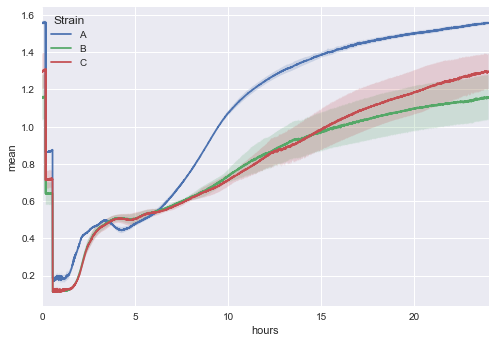

In [32]:
sns.set(style="darkgrid")
sns.tsplot(data=gr_growth, time="hours", unit="Environment",
           condition="Strain", value="mean")

In [ ]:
sns.tsplot(data=plotdf, time="hours", unit="Environment",
           condition="Strain", value="mean")

In [67]:
plotdf.head()

,Strain,Environment,Time,count,mean,std,CI_L,CI_R,hours
0,A,1,0,4,1.581725,0.007203,1.570263,1.593187,0.000000
1,A,1,20,4,1.580400,0.007365,1.568680,1.592120,0.005556
2,A,1,40,4,1.582325,0.007537,1.570332,1.594318,0.011111
3,A,1,60,4,1.580575,0.006590,1.570090,1.591060,0.016667
4,A,1,80,4,1.581125,0.007047,1.569912,1.592338,0.022222


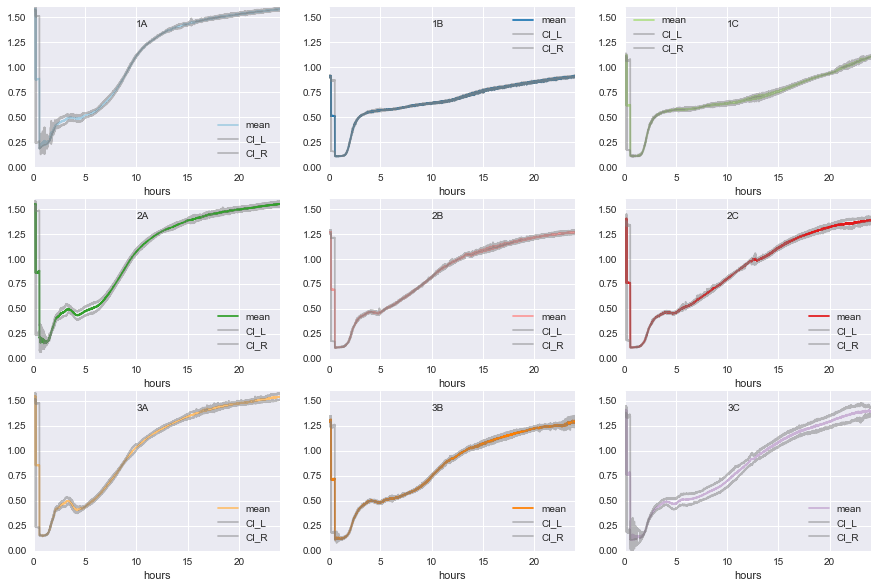

In [123]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
color_index = 0
for (environment, strain), ax in zip(plotdf.groupby(['Environment','Strain']), axes.flatten()):
    ax.set_ylim([0, 1.6])
    ax.set_xlim([0, 24])
    color = pcl.to_hex(palettable.colorbrewer.qualitative.Paired_12.mpl_colors[color_index])
    strain.plot(x='hours', y='mean', kind='line', ax=ax, c=color)
    strain.plot(x='hours', y='CI_L', kind='line', ax=ax,c='gray',alpha=0.5)
    strain.plot(x='hours', y='CI_R', kind='line', ax=ax,c='gray',alpha=0.5)
    ax.annotate(str(environment[0])+str(environment[1]), xy=(5, 1.4), xytext=(10, 1.4))
    color_index += 1

In [112]:
zip(plotdf.groupby(['Environment','Strain']), axes.flatten())[1][0][0]

(1, 'B')

In [130]:
for (environment, strain), ax in zip(plotdf.groupby(['Environment','Strain']), axes.flatten()):
    print str(environment[0])+str(environment[1])
    #print strain.head()
    #print ax

1A
1B
1C
2A
2B
2C
3A
3B
3C


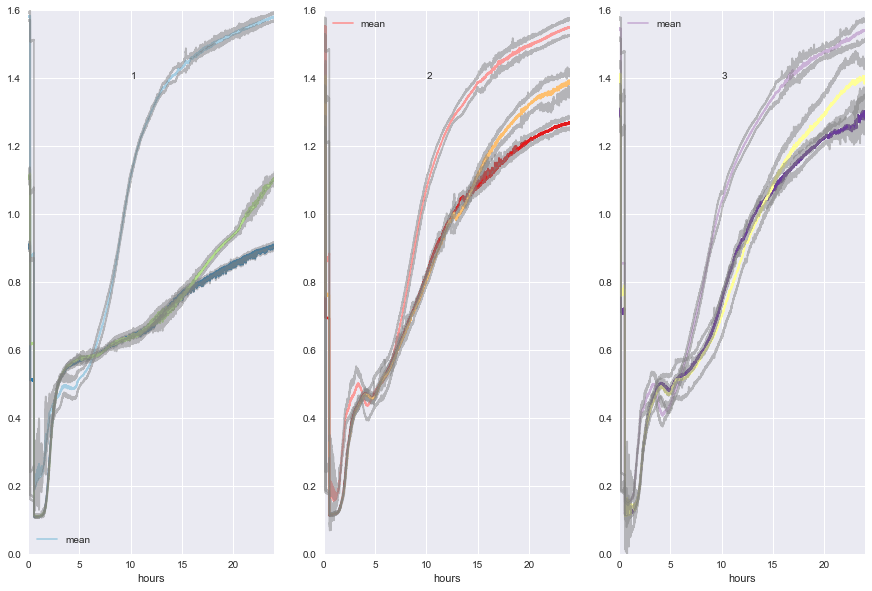

In [37]:
fig, axes = plt.subplots(1,3, figsize=(15,10))
color_index = 0
for (environment, strain), ax in zip(plotdf.groupby(['Environment']), axes.flatten()):
    ax.set_ylim([0, 1.6])
    ax.set_xlim([0, 24])
    color = pcl.to_hex(palettable.colorbrewer.qualitative.Paired_12.mpl_colors[color_index])
    strain.loc[strain['Strain']=='A',:].plot(x='hours', y='mean', kind='line', ax=ax, c=color)
    color_index += 1
    color = pcl.to_hex(palettable.colorbrewer.qualitative.Paired_12.mpl_colors[color_index])
    strain.loc[strain['Strain']=='B',:].plot(x='hours', y='mean', kind='line', ax=ax, c=color,legend=None)
    color_index += 1
    color = pcl.to_hex(palettable.colorbrewer.qualitative.Paired_12.mpl_colors[color_index])
    strain.loc[strain['Strain']=='C',:].plot(x='hours', y='mean', kind='line', ax=ax, c=color,legend=None)
    color_index += 1
    color = pcl.to_hex(palettable.colorbrewer.qualitative.Paired_12.mpl_colors[color_index])
    strain.loc[strain['Strain']=='A',:].plot(x='hours', y='CI_L', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    strain.loc[strain['Strain']=='A',:].plot(x='hours', y='CI_R', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    strain.loc[strain['Strain']=='B',:].plot(x='hours', y='CI_L', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    strain.loc[strain['Strain']=='B',:].plot(x='hours', y='CI_R', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    strain.loc[strain['Strain']=='C',:].plot(x='hours', y='CI_L', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    strain.loc[strain['Strain']=='C',:].plot(x='hours', y='CI_R', kind='line', ax=ax,c='gray',alpha=0.5,legend=None)
    ax.annotate(environment, xy=(5, 1.4), xytext=(10, 1.4))
    color_index += 1

In [137]:
for (environment, strain), ax in zip(plotdf.groupby(['Environment']), axes.flatten()):
    print environment
    print strain

1
      Strain  Environment   Time  count      mean       std      CI_L  \
0          A            1      0      4  1.581725  0.007203  1.570263   
1          A            1     20      4  1.580400  0.007365  1.568680   
2          A            1     40      4  1.582325  0.007537  1.570332   
3          A            1     60      4  1.580575  0.006590  1.570090   
4          A            1     80      4  1.581125  0.007047  1.569912   
5          A            1    100      4  1.581975  0.007011  1.570819   
6          A            1    120      4  1.580900  0.007671  1.568693   
7          A            1    140      4  1.581125  0.007507  1.569180   
8          A            1    160      4  1.581025  0.008219  1.567947   
9          A            1    180      4  1.580950  0.008136  1.568004   
10         A            1    200      4  1.580575  0.007247  1.569043   
11         A            1    220      4  1.581275  0.008222  1.568191   
12         A            1    240      4  1.580775

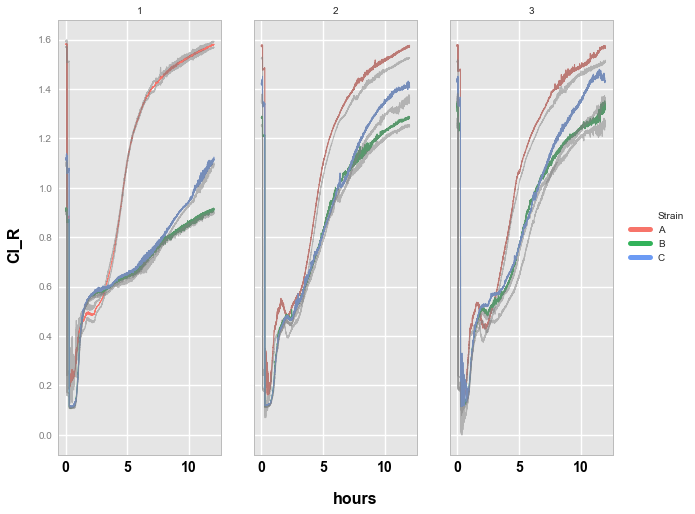

<ggplot: (318517465)>

In [66]:
from ggpy import *

ggplot(plotdf, aes(x='hours',y='mean', color='Strain')) +\
    geom_line(size=1) + \
    geom_line(aes(x='hours',y='CI_L'),alpha=.5, color = "gray")+\
    geom_line(aes(x='hours',y='CI_R'),alpha=.5, color = "gray")+\
    facet_grid(y='Environment')+\
    theme(axis_text_x=element_text(size=14, face="bold", color="black"),\
        axis_title_x=element_text(size=16, face="bold", color="black",vjust=-.01),\
        axis_title_y=element_text(size=16, face="bold", color="black",hjust=.02),\
        plot_title=element_text(size=0, face="bold"))

In [67]:
plotdf.head()

,Strain,Environment,Time,count,mean,std,CI_L,CI_R,hours
0,A,1,0,4,1.581725,0.007203,1.570263,1.593187,0.000000
1,A,1,20,4,1.580400,0.007365,1.568680,1.592120,0.005556
2,A,1,40,4,1.582325,0.007537,1.570332,1.594318,0.011111
3,A,1,60,4,1.580575,0.006590,1.570090,1.591060,0.016667
4,A,1,80,4,1.581125,0.007047,1.569912,1.592338,0.022222


TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

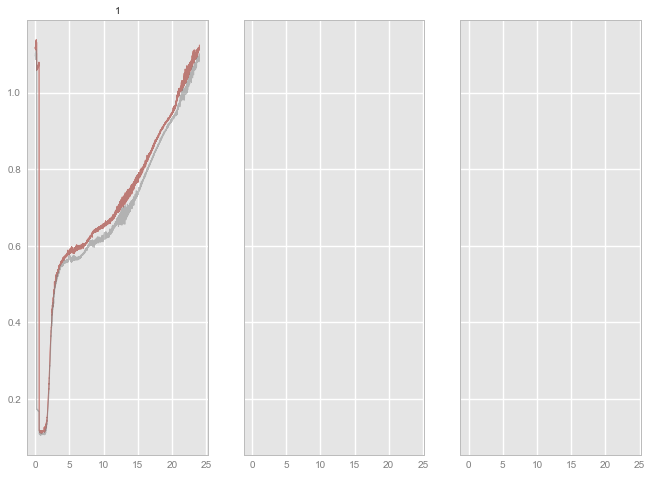

In [64]:
p+  geom_line(aes(x='hours',y='CI_R',data=),alpha=.5, color = "gray")